In [1]:
# Cell 1 - imports & paths
import sys
import os
sys.path.append(os.path.abspath(r"D:\Abhiijith\trader-sentiment-analysis"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_loader import load_sentiment, load_trades
from src.preprocessing import clean_sentiment, clean_trades, save_processed
from src.feature_engineering import compute_daily_metrics, merge_with_sentiment
from src.analysis import summarize_dataset, compare_by_sentiment, plot_trade_counts_time_series
from src.segmentation import define_simple_segments, cluster_traders
from src.models import prepare_features, train_classifiers, train_regressor
from src.utils import ensure_dirs, quick_stats,save_fig, save_report
ensure_dirs()
pd.set_option('display.max_columns', 200)

In [2]:
# Cell 2 - load data
sentiment = load_sentiment(r"D:\Abhiijith\trader-sentiment-analysis\data\raw\fear_greed_index.csv")
trades = load_trades(r"D:\Abhiijith\trader-sentiment-analysis\data\raw\historical_data.csv")
print("sentiment:", sentiment.shape)
print("trades:", trades.shape)

sentiment: (2644, 2)
trades: (211224, 16)


In [3]:
# Cell 3 - cleaning
sent_clean = clean_sentiment(sentiment)
trades_clean = clean_trades(trades)
save_processed(sent_clean, "sentiment_clean.csv")
save_processed(trades_clean, "trades_clean.csv")
sent_clean.head(), trades_clean.head()
print(trades_clean.columns)

Saved -> D:\Abhiijith\trader-sentiment-analysis\data\processed\sentiment_clean.csv
Saved -> D:\Abhiijith\trader-sentiment-analysis\data\processed\trades_clean.csv
Index(['account', 'coin', 'price', 'size tokens', 'trade_size', 'side',
       'start position', 'direction', 'pnl', 'transaction hash', 'order id',
       'crossed', 'fee', 'trade id', 'timestamp', 'date'],
      dtype='object')


In [4]:
# Cell 4 - daily metrics & merge
daily_metrics = compute_daily_metrics(trades_clean)
daily_metrics.head()
merged = merge_with_sentiment(daily_metrics, sent_clean)
merged.to_csv("data/processed/merged_data.csv", index=False)
merged.head()

,date,account,daily_pnl,trade_count,avg_trade_size,median_trade_size,worst_trade_pnl,win_count,loss_count,win_rate,long_count,short_count,long_short_ratio,classification,pnl_lag1,pnl_roll3,winrate_lag1,tradecount_roll3
146,2024-06-12,0x083384f897ee0f19899168e3b1bec365f52a9012,-175611.000056,33,36736.362424,796.08,-117990.10410,0.0,33.0,0.000000,0.0,0.0,0.0,Greed,0.000000,0.000000,0.0,0.000000
271,2024-11-11,0x083384f897ee0f19899168e3b1bec365f52a9012,0.000000,177,5089.718249,2736.64,0.00000,0.0,177.0,0.000000,0.0,0.0,0.0,Extreme Greed,-175611.000056,0.000000,0.0,0.000000
339,2025-01-03,0x083384f897ee0f19899168e3b1bec365f52a9012,9482.221441,45,2985.797556,2999.15,0.00000,36.0,9.0,0.800000,0.0,0.0,0.0,Greed,0.000000,-55376.259538,0.0,85.000000
373,2025-02-02,0x083384f897ee0f19899168e3b1bec365f52a9012,76710.000000,10,185847.000000,21499.76,0.00000,9.0,1.0,0.900000,0.0,0.0,0.0,Greed,9482.221441,28730.740480,0.8,77.333333
416,2025-03-02,0x083384f897ee0f19899168e3b1bec365f52a9012,101011.685664,839,23593.019857,1008.71,-19841.24014,256.0,583.0,0.305125,0.0,0.0,0.0,Fear,76710.000000,62401.302368,0.9,298.000000


Trades shape: (79225, 16)
Sentiment shape: (2644, 2)

Trades missing values:
 account             0
coin                0
price               0
size tokens         0
trade_size          0
side                0
start position      0
direction           0
pnl                 0
transaction hash    0
order id            0
crossed             0
fee                 0
trade id            0
timestamp           0
date                0
dtype: int64

Sentiment missing values:
 date              0
classification    0
dtype: int64

Trades duplicates: 0

Sentiment duplicates: 0
  sentiment_coarse  mean_daily_pnl  median_daily_pnl  mean_win_rate  \
0             Fear     9387.502733        229.993075       0.319269   
1            Greed     5830.119499        130.487079       0.346771   
2            Other     5142.061123        225.551629       0.361052   

   avg_trade_count  
0        85.236842  
1        55.818482  
2       111.393720  


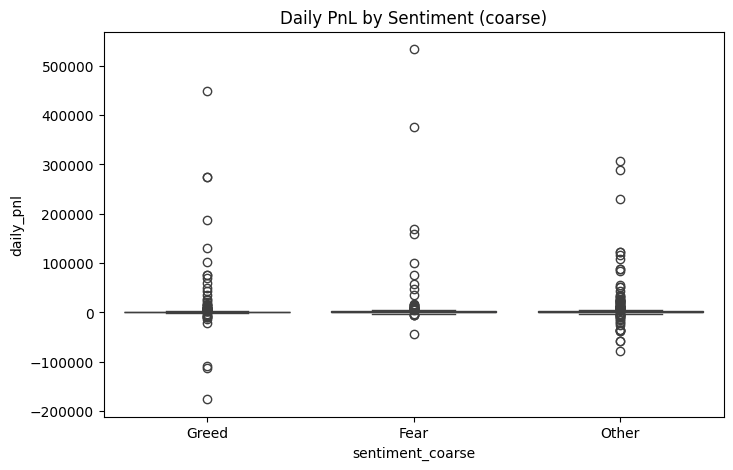

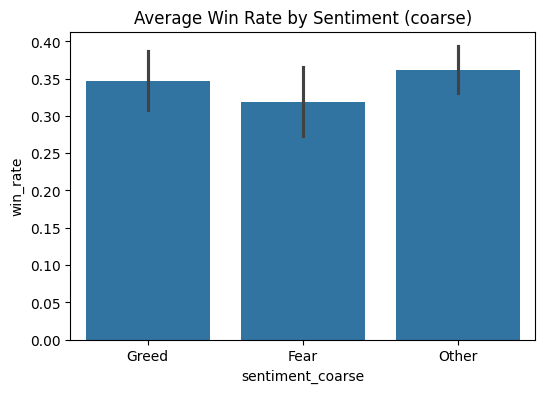

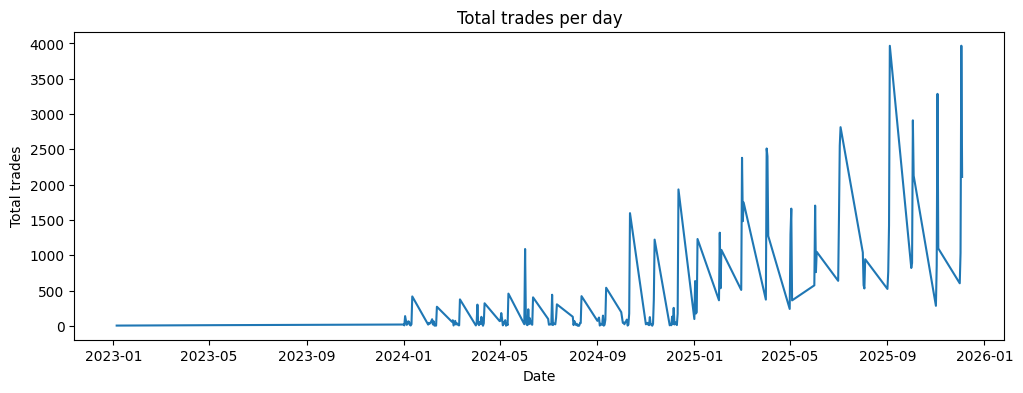

In [5]:
# Cell 5 - exploratory analysis
summarize_dataset(trades_clean, sent_clean)
stat = compare_by_sentiment(merged)
plot_trade_counts_time_series(merged)

In [6]:
# Cell 6 - segmentation & clustering

segged = define_simple_segments(merged)

# trader-level aggregation
features = segged.groupby('account').agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'avg_trade_size': 'mean',
    'trade_count': 'mean'
}).fillna(0)

clusters, sil = cluster_traders(features, n_clusters=3)

print("Silhouette score:", sil)

clusters.groupby('cluster').mean()

Silhouette score: 0.5722298283902627


,daily_pnl,win_rate,avg_trade_size,trade_count
cluster,,,,
0,28247.550457,0.330584,9191.504151,248.247557
1,2369.578848,0.343920,7151.980639,88.268260
2,113285.636509,0.470400,41505.831913,226.000000


In [7]:
# Cell 7 - modeling
X, y, df_for_model = prepare_features(merged)
clf_models = train_classifiers(X, y)
print("Logistic acc:", clf_models['logistic']['acc'])
print("RF acc:", clf_models['random_forest']['acc'])
# regression target example: predict next-day daily_pnl value
df_for_model['next_daily_pnl'] = df_for_model['next_daily_pnl'].fillna(0)
reg = train_regressor(X, df_for_model['next_daily_pnl_log'])
print("Regressor MSE:", reg['mse'], "R2:", reg['r2'])

Logistic acc: 0.6070038910505836
RF acc: 0.6186770428015564
Regressor MSE: 22.907423923880664 R2: -0.06217573729410164


In [8]:
# Cell 8 - save key outputs and show insights
merged.to_csv("D:/Abhiijith/trader-sentiment-analysis/data/processed/merged_data.csv", index=False)
features.to_csv("D:/Abhiijith/trader-sentiment-analysis/data/processed/trader_features.csv", index=True)
print("Saved merged and feature files to data/processed/")
# Quick insight example
by_sent = merged.groupby('classification')['daily_pnl'].agg(['mean','median','count']).sort_values('mean', ascending=False)
by_sent
plt.figure(figsize=(8,5))
merged['daily_pnl'].hist()
save_fig("daily_pnl_distribution.png")
save_report(merged, "merged_dataset.csv")

Saved merged and feature files to data/processed/
Saved figure → D:\Abhiijith\trader-sentiment-analysis\outputs\figures\daily_pnl_distribution.png
Saved report → D:\Abhiijith\trader-sentiment-analysis\outputs\reports\merged_dataset.csv


WindowsPath('D:/Abhiijith/trader-sentiment-analysis/outputs/reports/merged_dataset.csv')